# 정형 데이터마이닝

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from joblib import Parallel, delayed

1.&nbsp; "BlackFriday"데이터에서 Product_Category_2, Product_Category_3의 NA 값을 0값으로 대체하고 Product_Category_1, 2, 3 변수의 값을 다 더한 Product_all 변수를 생성하여 추가하라.<br>
그리고 User_ID를 character변수로, Occupation, Marital_Status, Product_Category_1, Product_Category_2, Product_Category_3 변수를 범주형 변수로 변환하시오.<br>
마지막으로 범주형 변수인 Gender, Age, City_Category, Stay_In_Current_City_Year를 더미변수로 변환해서 BlackFriday 데이터에 추가하시오.

In [2]:
data_path = '/hdd/data/adp_data/BlackFriday.csv'
BlackFriday = pd.read_csv(data_path)
BlackFriday.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [3]:
BlackFriday = BlackFriday.sample(frac = 0.1, random_state = 526)

In [4]:
BlackFriday.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53758 entries, 174309 to 337012
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User_ID                     53758 non-null  int64  
 1   Product_ID                  53758 non-null  object 
 2   Gender                      53758 non-null  object 
 3   Age                         53758 non-null  object 
 4   Occupation                  53758 non-null  int64  
 5   City_Category               53758 non-null  object 
 6   Stay_In_Current_City_Years  53758 non-null  object 
 7   Marital_Status              53758 non-null  int64  
 8   Product_Category_1          53758 non-null  int64  
 9   Product_Category_2          37071 non-null  float64
 10  Product_Category_3          16520 non-null  float64
 11  Purchase                    53758 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 5.3+ MB


In [5]:
BlackFriday['Product_Category_2'] = BlackFriday['Product_Category_2'].fillna(0)
BlackFriday['Product_Category_3'] = BlackFriday['Product_Category_3'].fillna(0)

BlackFriday['Product_all'] = (
    BlackFriday['Product_Category_1'] +
    BlackFriday['Product_Category_2'] +
    BlackFriday['Product_Category_3']
)

BlackFriday['User_ID'] = BlackFriday['User_ID'].astype(str)
BlackFriday['Occupation'] = BlackFriday['Occupation'].astype('category')
BlackFriday['Marital_Status'] = BlackFriday['Marital_Status'].astype('category')
BlackFriday['Product_Category_1'] = BlackFriday['Product_Category_1'].astype('category')
BlackFriday['Product_Category_2'] = BlackFriday['Product_Category_2'].astype('category')
BlackFriday['Product_Category_3'] = BlackFriday['Product_Category_3'].astype('category')

dummy_vars = ['Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years']
BlackFriday = pd.get_dummies(BlackFriday, columns = dummy_vars, drop_first = True)

BlackFriday.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53758 entries, 174309 to 337012
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   User_ID                        53758 non-null  object  
 1   Product_ID                     53758 non-null  object  
 2   Occupation                     53758 non-null  category
 3   Marital_Status                 53758 non-null  category
 4   Product_Category_1             53758 non-null  category
 5   Product_Category_2             53758 non-null  category
 6   Product_Category_3             53758 non-null  category
 7   Purchase                       53758 non-null  int64   
 8   Product_all                    53758 non-null  float64 
 9   Gender_M                       53758 non-null  bool    
 10  Age_18-25                      53758 non-null  bool    
 11  Age_26-35                      53758 non-null  bool    
 12  Age_36-45                      

2.&nbsp; 1.에서 전처리가 완료된 데이터에서 User_ID, Product_ID, Gender, Age, City_Category, Stay_In_Current_City_Year, Product_all 변수를 제외한 나머지 변수들을 활용하여 kmeans 군집분석을 수행하고 해석하시오. (범주형 변수는 수치형 변수로 변환하여 분석에 활용하시오)<br>
그리고 최적의 군집 개수를 찾아서 만일 군집 개수가 이전 결과와 다르면 분석을 다시 수행하여 해석하시오.

In [6]:
columns_to_exclude = [
    'User_ID',
    'Product_ID',
    'Gender_M',
    'Age_18-25', 'Age_26-35', 'Age_36-45', 'Age_46-50', 'Age_51-55', 'Age_55+',
    'City_Category_B', 'City_Category_C',
    'Stay_In_Current_City_Years_1', 'Stay_In_Current_City_Years_2', 'Stay_In_Current_City_Years_3', 'Stay_In_Current_City_Years_4+',
    'Product_all'
]
data_for_clustering = BlackFriday.drop(columns = columns_to_exclude)

label_encoders = {}
for col in data_for_clustering.select_dtypes(include = ['category']).columns:
    le = LabelEncoder()
    data_for_clustering[col] = le.fit_transform(data_for_clustering[col])

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_clustering)

5-means clustering is done.
4-means clustering is done.
7-means clustering is done.
10-means clustering is done.
9-means clustering is done.
6-means clustering is done.
3-means clustering is done.
2-means clustering is done.
8-means clustering is done.


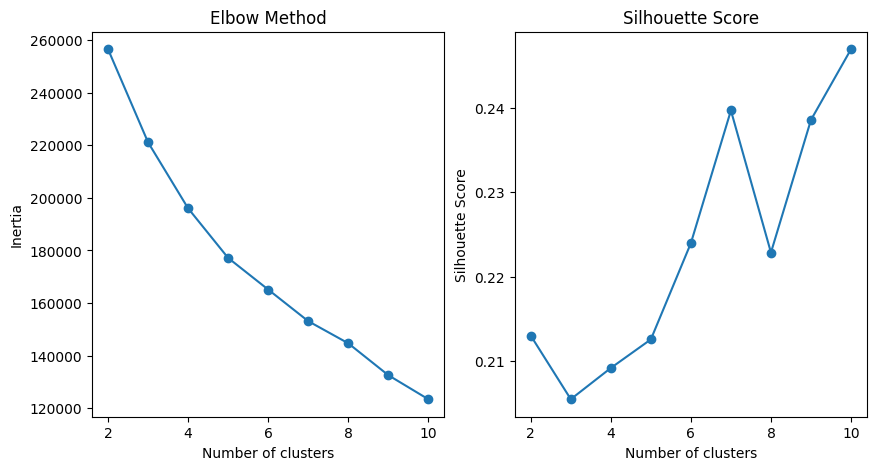

In [7]:
'''
inertia = []
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters = k, random_state = 526, n_init = 10)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(data_scaled, kmeans.labels_))
    print(f'{k}-means cluster is done.')
'''

def compute_kmeans(k):
    kmeans = KMeans(n_clusters = k, random_state = 526, n_init = 3)
    kmeans.fit(data_scaled)
    inertia = kmeans.inertia_
    silhouette = silhouette_score(data_scaled, kmeans.labels_)
    print(f'{k}-means clustering is done.')
    return k, inertia, silhouette

k_values = range(2, 11)
results = Parallel(n_jobs = 12)(delayed(compute_kmeans)(k) for k in k_values)

k_values, inertia, silhouette_scores = zip(*results)

plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.show()

In [8]:
k_optimal = k_values[silhouette_scores.index(max(silhouette_scores))]
kmeans_optimal = KMeans(n_clusters = k_optimal, random_state = 526, n_init = 10)
kmeans_optimal.fit(data_scaled)

BlackFriday['clust'] = kmeans_optimal.labels_

3.&nbsp; 최적의 군집 개수를 찾아 재수행한 군집분석의 결과로 분류된 군집번호를 원본 데이터인 BlackFriday데이터의 각 행에 맞게 labelling하여 clust라는 변수로 저장하고, cluster별 특성을 파악하여 설명하시오.

In [9]:
cluster_summary = BlackFriday.groupby('clust').mean(numeric_only = True)
display(cluster_summary)

BlackFriday[['clust']].value_counts().sort_index()

,Purchase,Product_all,Gender_M,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,City_Category_B,City_Category_C,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+
clust,,,,,,,,,,,,,,,
0,13528.295466,17.614875,0.797759,0.142639,0.376465,0.221600,0.101885,0.089659,0.043301,0.429445,0.298523,0.360672,0.180336,0.175242,0.147224
1,6340.180800,8.366491,0.731180,0.097156,0.382705,0.196757,0.142839,0.119032,0.061511,0.414876,0.302921,0.374340,0.178355,0.168962,0.143740
2,11779.403034,26.018327,0.787141,0.239147,0.411296,0.211507,0.039507,0.032597,0.023434,0.412498,0.324170,0.342346,0.188674,0.185970,0.153973
3,6849.284310,8.975713,0.818234,0.155551,0.425598,0.212606,0.056862,0.033153,0.028142,0.409599,0.302814,0.338281,0.171935,0.183500,0.162105
4,6454.695740,8.432208,0.687835,0.308950,0.411844,0.183012,0.030547,0.031350,0.014603,0.441586,0.258039,0.328510,0.192792,0.179126,0.164121
5,6452.340736,22.125408,0.703244,0.086654,0.369258,0.196168,0.166558,0.125844,0.055519,0.425648,0.314174,0.372741,0.172654,0.161986,0.156325
6,15703.296381,12.429979,0.800455,0.266060,0.401743,0.200493,0.027857,0.028994,0.026341,0.417472,0.324995,0.347735,0.194050,0.165435,0.154633
7,11819.959321,25.887318,0.779639,0.095062,0.389819,0.181423,0.151403,0.124647,0.057646,0.413748,0.350228,0.372634,0.168371,0.163150,0.163367
8,6373.788150,22.263869,0.711614,0.240453,0.410498,0.195820,0.040547,0.036304,0.026717,0.427157,0.292786,0.352035,0.178218,0.177275,0.157473


clust
0        1963
1        7771
2        6657
3        5188
4        7464
5        4593
6        5277
7        4597
8        6363
9        3885
Name: count, dtype: int64